In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import linregress
np.random.seed(1265)
from functools import reduce
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from shapely.geometry import Point, MultiPolygon, Polygon
from shapely.ops import unary_union
import os

###Machine Learning
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

##Supervised Learning
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

##Deep learning session
import tensorflow as tf
from keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adagrad

np.random.seed(123)
tf.random.set_seed(123)

# The Complete Model

### Functions that prepare the data

In [2]:
string_brackets_columns = ['resoFacts.patioAndPorchFeatures', 'resoFacts.waterSource', 'resoFacts.exteriorFeatures',
                           'resoFacts.interiorFeatures', 'resoFacts.communityFeatures', 'resoFacts.constructionMaterials',
                           'resoFacts.foundationDetails', 'resoFacts.utilities', 'resoFacts.appliances', 
                           'resoFacts.flooring', 'resoFacts.parkingFeatures',
                           'resoFacts.lotFeatures', 'resoFacts.fireplaceFeatures', 'resoFacts.laundryFeatures', 
                           'resoFacts.propertySubType', 'resoFacts.securityFeatures', 
                           'resoFacts.cooling', 'resoFacts.windowFeatures', 'resoFacts.heating', 'resoFacts.sewer', 
                           'resoFacts.poolFeatures']

string_comma_columns = ['resoFacts.architecturalStyle', 
                        'resoFacts.fencing', 'resoFacts.roofType']

t = string_brackets_columns + string_comma_columns
Selected_features = list(set(t) - set(['resoFacts.utilities', 'resoFacts.propertySubType']))

Year_list2022 = ['2022']
Month_list2022 = ['July', 'August', 'September', 'October', 'November', 'December']
Year_list2023 = ['2023']
Month_list2023 = ['January', 'February', 'March']

##This is a dictionary that store the datasets for every month
monthly_data_dict1 = dict()
path_abs = "C:\\Users\\Khoatruong\\DATA365\\House Capstone Project\\Data cleaning\\Houses_categorical_property\\"

def read_house_data(Monthlist, Yearlist, monthly_data_dict1):
    for Year in Yearlist:
        for Month in Monthlist:
            main_df = pd.read_csv("C:\\Users\\Khoatruong\\DATA365\\House Capstone Project\\Data cleaning\\Clean_data_House_properties\\" + Month + '_' + Year + '\\houses_properties_' + Month + '.csv')
            cols = main_df.columns.tolist()

            ##Rename some columns
            for c in cols:
                if 'resoFacts.' in c:
                    feature = c.split('.')[1]
                    main_df[feature] = main_df[c]
                    main_df.drop(labels = [c], axis = 1, inplace = True)

            ##Drop unimportant features 
            main_df.drop(labels = ['streetAddress', 'countyId', 'hasCooling', 'hasHeating'], axis = 1, inplace = True)
            main_df.reset_index(drop = True, inplace = True)

            ##Join the categorical dataframes
            for category in Selected_features:
                ft = category.split('.')[1]
                name = 'houses' + '_' + ft + '.csv'
                df_cat = pd.read_csv(path_abs + Month + '_' + Year + '\\' + name)
                main_df = pd.merge(main_df, df_cat, how = 'left', on = 'zpid')

            string_list = ['city', 'county', 'SchoolDistrict', 'levels']
            for string in string_list:
                main_df[string] = main_df[string].str.lower()
            monthly_data_dict1[Month + '_' + Year] = main_df

In [3]:
read_house_data(Month_list2022, Year_list2022, monthly_data_dict1)
read_house_data(Month_list2023, Year_list2023, monthly_data_dict1)

In [4]:
for Month, df in monthly_data_dict1.items():
    monthly_data_dict1[Month]['zipcode'] = monthly_data_dict1[Month]['zipcode'].astype('int64')

for Month, df in monthly_data_dict1.items():
    monthly_data_dict1[Month]['price/livingsqft'] = monthly_data_dict1[Month]['price'] / monthly_data_dict1[Month]['livingAreaValue']
    monthly_data_dict1[Month]['price/lotsqft'] = monthly_data_dict1[Month]['price'] / monthly_data_dict1[Month]['lotArea']
    monthly_data_dict1[Month]['liv/lot_ratio'] = monthly_data_dict1[Month]['livingAreaValue'] / monthly_data_dict1[Month]['lotArea']
    monthly_data_dict1[Month]['living_price'] = df.apply(lambda row: row['price'] if row['liv/lot_ratio'] >= 1 else row['liv/lot_ratio']*row['price'], axis=1)
    levels_df = pd.get_dummies(monthly_data_dict1[Month]['levels'], prefix = 'levels')
    df = pd.concat([df.copy(), levels_df], axis=1)
    df = df.copy().drop('levels', axis = 1)
    ###Looking at a more dense location
    df = df.copy().drop(df[(df['lotArea'] == 0) | (df['price/lotsqft'] > 1000) | (df['liv/lot_ratio'] > 2)
                           | (df['lotArea'] > 100000)].index)
    df = df.reset_index(drop = True)
    monthly_data_dict1[Month] = df

In [5]:
##Need to categorize levels
True_False_features = ['isSeniorCommunity', 'hasAssociation', 'hasPrivatePool', 'hasGarage',
                       'hasAttachedGarage', 'hasCarport', 'hasSpa', 'hasFireplace', 'isNewConstruction']

Numerical_features = ['monthlyHoaFee', 'liv/lot_ratio', 'bedrooms', 'carportSpaces', 'garageSpaces', 
                      'coveredSpaces', 'parking', 'bathroomsHalf', 'bathroomsFull', 'fireplaces']

##levels, laundry features, flooring features, construction features, exterior features, interior features, appliances,
##foundations, lotFeatures, securityFeatures, sewer of the house.

Categorical_features = ['levels_one', 'levels_one and one half', 'levels_two', 'levels_three or more',
                        'levels_multi/split', 'laundryFeatures_none', 'laundryFeatures_electricdryerhookup',
                        'laundryFeatures_fullsizew/darea', 'laundryFeatures_washerhookup', 'laundryFeatures_utilityroom',
                        'laundryFeatures_other', 'flooring_carpet', 'flooring_laminate', 'flooring_vinyl',
                        'flooring_ceramictile', 'flooring_hardwood', 'flooring_other', 'flooring_luxuryvinylplank',
                        'flooring_tile', 'flooring_wood', 'constructionMaterials_siding', 'constructionMaterials_wood',
                        'constructionMaterials_brick', 'constructionMaterials_other', 'constructionMaterials_frame',
                        'constructionMaterials_fibercement', 'constructionMaterials_rock/stone', 'exteriorFeatures_coveredpatio/porch',
                        'exteriorFeatures_storage', 'exteriorFeatures_other', 'exteriorFeatures_raingutters',
                        'exteriorFeatures_lighting', 'exteriorFeatures_privateyard', 'interiorFeatures_granitecounters',
                        'interiorFeatures_highspeedinternetavailable', 'interiorFeatures_other', 'interiorFeatures_cabletvavailable',
                        'interiorFeatures_eat-inkitchen', 'interiorFeatures_pantry', 'interiorFeatures_openfloorplan',
                        'interiorFeatures_kitchenisland', 'interiorFeatures_vaultedceiling(s)', 
                        'interiorFeatures_walk-incloset(s)', 'interiorFeatures_built-infeatures', 'interiorFeatures_decorativelighting',
                        'interiorFeatures_smarthomesystem', 'interiorFeatures_doublevanity', 'interiorFeatures_flatscreenwiring',
                        'interiorFeatures_chandelier', 'interiorFeatures_soundsystemwiring', 'interiorFeatures_wetbar',
                        'appliances_electricrange', 'appliances_refrigerator', 'appliances_gasrange', 'appliances_dishwasher',
                        'appliances_gasoven', 'appliances_gaswaterheater', 'appliances_electricoven', 'appliances_microwave',
                        'appliances_electriccooktop', 'appliances_electricwaterheater', 'appliances_ventedexhaustfan',
                        'appliances_disposal', 'appliances_plumbedforgasinkitchen', 'appliances_tanklesswaterheater',
                        'appliances_gascooktop', 'appliances_doubleoven', 'appliances_convectionoven', 'appliances_built-ingasrange', 
                        'appliances_other', 'foundationDetails_pillar/post/pier', 'foundationDetails_slab',
                        'foundationDetails_other', 'lotFeatures_lrg.backyardgrass', 'lotFeatures_acreage',
                        'lotFeatures_cornerlot', 'lotFeatures_fewtrees', 'lotFeatures_none', 'lotFeatures_interiorlot',
                        'lotFeatures_subdivided', 'lotFeatures_cul-de-sac', 'lotFeatures_landscaped',
                        'lotFeatures_sprinklersystem', 'lotFeatures_other', 'lotFeatures_manytrees',
                        'securityFeatures_none', 'securityFeatures_smokedetector(s)', 'securityFeatures_carbonmonoxidedetector(s)',
                        'securityFeatures_firealarm', 'securityFeatures_securitysystem',
                        'securityFeatures_securitysystemowned', 'securityFeatures_burglar', 'securityFeatures_prewired',
                        'securityFeatures_other', 'sewer_citysewer', 'sewer_aerobicseptic', 'sewer_septic',
                        'sewer_other']

In [6]:
location_cols = ['zpid', 'latitude', 'longitude', 'county', 'SchoolDistrict', 'zipcode', 
                 'liv/lot_ratio', 'price/lotsqft', 'price/livingsqft']
monthly_location2 = dict()
for Month, df in monthly_data_dict1.items():
    ##Store the location data into this dictionary
    df_location = df.copy()[location_cols]
    monthly_location2[Month] = df_location

In [7]:
shape_df2 = gpd.read_file('ALL_US_county/tl_rd22_us_county.shp')
shape_df2['NAME'] = shape_df2['NAME'].str.lower()
shape_df2['INTPTLAT'] = shape_df2['INTPTLAT'].astype('float64')
shape_df2['INTPTLON'] = shape_df2['INTPTLON'].astype('float64')

shape_df3 = gpd.read_file('Texas_SchoolDistrict/tl_rd22_48_unsd.shp')
shape_df3['NAME'] = shape_df3['NAME'].str.lower().replace('independent school district', 'isd', regex = True)
shape_df3['INTPTLAT'] = shape_df3['INTPTLAT'].astype('float64')
shape_df3['INTPTLON'] = shape_df3['INTPTLON'].astype('float64')

shape_df4 = gpd.read_file('ALL_US_zipcode/tl_rd22_us_zcta520.shp')
shape_df4['ZCTA5CE20'] = shape_df4['ZCTA5CE20'].astype('int64')
shape_df4['GEOID20'] = shape_df4['GEOID20'].astype('int64')
shape_df4['INTPTLAT20'] = shape_df4['INTPTLAT20'].astype('float64')
shape_df4['INTPTLON20'] = shape_df4['INTPTLON20'].astype('float64')
shape_df4['INTPTLAT'] = shape_df4['INTPTLAT20']
shape_df4['INTPTLON'] = shape_df4['INTPTLON20']

In [8]:
for Month, df in monthly_location2.items():
    all_counties_list = np.sort(df['county'].unique())
    counties_location_df = shape_df2.copy()
    counties_location_df = counties_location_df[(counties_location_df['NAME'].isin(all_counties_list)) & 
                                                (counties_location_df['GEOID'].str.contains('48'))].reset_index(drop = True)
    counties_location_df['county_lat'] = counties_location_df['INTPTLAT']
    counties_location_df['county_long'] = counties_location_df['INTPTLON']
    counties_location_df['county'] = counties_location_df['NAME']
    
    all_SD_list = np.sort(df['SchoolDistrict'].unique())
    SD_location_df = shape_df3.copy()
    SD_location_df = SD_location_df[SD_location_df['NAME'].isin(all_SD_list) &
                                   (SD_location_df['INTPTLON'] >= -98.5) & 
                                   (SD_location_df['INTPTLON'] <= -95.8) &
                                   (SD_location_df['INTPTLAT'] >= 32) &
                                   (SD_location_df['INTPTLAT'] <= 33.70)].reset_index(drop = True)
    SD_location_df['SD_lat'] = SD_location_df['INTPTLAT']
    SD_location_df['SD_long'] = SD_location_df['INTPTLON']
    SD_location_df['SchoolDistrict'] = SD_location_df['NAME']
    
    all_zipcode_list = np.sort(df['zipcode'].unique())
    zipcode_location_df = shape_df4.copy()
    zipcode_location_df = zipcode_location_df[zipcode_location_df['ZCTA5CE20'].isin(all_zipcode_list) &
                                             (zipcode_location_df['INTPTLON20'] >= -98.5) & 
                                             (zipcode_location_df['INTPTLON20'] <= -95.8) &
                                             (zipcode_location_df['INTPTLAT20'] >= 32) &
                                             (zipcode_location_df['INTPTLAT20'] <= 33.70)].reset_index(drop = True)
    zipcode_location_df['zipcode_lat'] = zipcode_location_df['INTPTLAT']
    zipcode_location_df['zipcode_long'] = zipcode_location_df['INTPTLON']
    zipcode_location_df['zipcode'] = zipcode_location_df['ZCTA5CE20']
    
    merge_df = pd.merge(df, counties_location_df.copy()[['county', 'county_lat', 'county_long']], on=['county'], how='left')
    merge_df = pd.merge(merge_df, SD_location_df.copy()[['SchoolDistrict', 'SD_lat', 'SD_long']], on=['SchoolDistrict'], how='left')
    merge_df = pd.merge(merge_df, zipcode_location_df.copy()[['zipcode', 'zipcode_lat', 'zipcode_long']], on=['zipcode'], how='left')
    
    new_df = merge_df.copy()[['zpid', 'latitude', 'longitude', 'county_lat', 
                              'county_long', 'SD_lat', 'SD_long', 'zipcode_lat', 'zipcode_long', 
                              'price/livingsqft', 'price/lotsqft', 'liv/lot_ratio']]
    
    ###Check for null coords, if they are null, fill them with the coordinates of the houses
    new_df['SD_lat'].fillna(new_df['latitude'], inplace = True)
    new_df['SD_long'].fillna(new_df['longitude'], inplace = True)
    
    new_df['zipcode_lat'].fillna(new_df['latitude'], inplace = True)
    new_df['zipcode_long'].fillna(new_df['longitude'], inplace = True)
    
    new_df['county_lat'].fillna(new_df['latitude'], inplace = True)
    new_df['county_long'].fillna(new_df['longitude'], inplace = True)
    Monthly_path = 'Location_data3/' + Month
    if not os.path.exists(Monthly_path):
        os.makedirs(Monthly_path)
    
    new_df.to_csv(Monthly_path + '/' + Month + '_houses_location.csv', index = False)

In [35]:
Month_list = ['July_2022', 'August_2022', 'September_2022', 'October_2022', 'November_2022',
              'December_2022', 'January_2023', 'February_2023', 'March_2023']
monthly_location_dict1 = dict()

for month in Month_list:
    ###Read in all the datasets
    Month_path = 'Location_data3/' + month + '/' + month + '_houses_location.csv'
    df_location = pd.read_csv(Month_path)
    monthly_location_dict1[month] = df_location

In [10]:
def transform_data(df, True_False_features, Numerical_features, Categorical_features):
    df_transformed = df.copy()
    for ft in True_False_features:
        df_transformed.loc[df_transformed[ft] == True, ft] = 1
        df_transformed.loc[df_transformed[ft] == False, ft] = 0
        df_transformed[ft] = df_transformed[ft].astype(int)
    return df_transformed[True_False_features + Numerical_features + Categorical_features + ['living_price']]

In [11]:
def prep_combination_data(splits, scaler, original_df, df_model1, df_model2, Numerical_features):
    data1 = df_model1.to_numpy()
    data2 = df_model2.to_numpy()
    cv = KFold(n_splits = splits, shuffle = True, random_state = 0)
    cv.split(original_df)

    train_set_dict1 = dict()
    train_target_dict1 = dict()
    scaled_train_set1 = dict()
    scaled_train_target1 = dict()

    test_set_dict1 = dict()
    test_target_dict1 = dict()
    scaled_test_set1 = dict()
    scaled_test_target1 = dict()
    
    train_set_dict2 = dict()
    train_target_dict2 = dict()
    scaled_train_set2 = dict()
    scaled_train_target2 = dict()

    test_set_dict2 = dict()
    test_target_dict2 = dict()
    scaled_test_set2 = dict()
    scaled_test_target2 = dict()

    ###Create 2 different unique dictionary to track the prediction of real price
    original_train = dict()
    original_test = dict()
    
    ###Store K folds data into dictionary
    for i, (train_index, test_index) in enumerate(cv.split(original_df)):
        ###1 means location data
        train_set1 = df_model1.iloc[train_index].iloc[:, :-1]
        train_target1 = df_model1.iloc[train_index].iloc[:, -1]
        train_set_dict1['Fold ' + str(i)] = train_set1.copy()
        train_target_dict1['Fold ' + str(i)] = train_target1.copy()

        test_set1 = df_model1.iloc[test_index].iloc[:, :-1]
        test_target1 = df_model1.iloc[test_index].iloc[:, -1]
        test_set_dict1['Fold ' + str(i)] = test_set1.copy()
        test_target_dict1['Fold ' + str(i)] = test_target1.copy()
        
        ###2 means properties data
        train_set2 = df_model2.iloc[train_index].iloc[:, :-1]
        train_target2 = df_model2.iloc[train_index].iloc[:, -1]
        train_set_dict2['Fold ' + str(i)] = train_set2.copy()
        train_target_dict2['Fold ' + str(i)] = train_target2.copy()

        test_set2 = df_model2.iloc[test_index].iloc[:, :-1]
        test_target2 = df_model2.iloc[test_index].iloc[:, -1]
        test_set_dict2['Fold ' + str(i)] = test_set2.copy()
        test_target_dict2['Fold ' + str(i)] = test_target2.copy()
        
        ###Keeping the liv/lot_ratio, lot_area, living area
        original_train['Fold ' + str(i)] = original_df.iloc[train_index][['zpid', 'livingAreaValue', 'lotArea', 'liv/lot_ratio']]
        original_test['Fold ' + str(i)] = original_df.iloc[test_index][['zpid', 'livingAreaValue', 'lotArea', 'liv/lot_ratio']]
        
        ###for location data
        the_scaler1 = scaler
        scaled_train_set1['Fold ' + str(i)] = the_scaler1.fit_transform(train_set1)
        scaled_train_target1['Fold ' + str(i)] = np.log(train_target_dict1['Fold ' + str(i)]).to_numpy().reshape(-1, 1)
        scaled_test_set1['Fold ' + str(i)] = the_scaler1.transform(test_set1)
        scaled_test_target1['Fold ' + str(i)] = np.log(test_target_dict1['Fold ' + str(i)]).to_numpy().reshape(-1, 1)
        
        ###for properties data
        the_scaler2 = scaler
        scaled_train2 = train_set2.copy()
        scaled_test2 = test_set2.copy()
        num_transformer = ColumnTransformer(transformers=[('num', MinMaxScaler(), Numerical_features)])
        scaled_train2[Numerical_features] = num_transformer.fit_transform(train_set2.copy()[Numerical_features])
        scaled_test2[Numerical_features] = num_transformer.transform(test_set2.copy()[Numerical_features])
        scaled_train_set2['Fold ' + str(i)] = scaled_train2
        scaled_train_target2['Fold ' + str(i)] = np.log(train_target_dict2['Fold ' + str(i)]).to_numpy().reshape(-1, 1)
        scaled_test_set2['Fold ' + str(i)] = scaled_test2
        scaled_test_target2['Fold ' + str(i)] = np.log(test_target_dict2['Fold ' + str(i)]).to_numpy().reshape(-1, 1)
        
    return (train_set_dict1, train_target_dict1, scaled_train_set1, scaled_train_target1,
            test_set_dict1, test_target_dict1, scaled_test_set1, scaled_test_target1,
            train_set_dict2, train_target_dict2, scaled_train_set2, scaled_train_target2,
            test_set_dict2, test_target_dict2, scaled_test_set2, scaled_test_target2, original_train, original_test)

## Functions that define the model architecture

In [12]:
def ann_location_generator(input_shape):
    T = input_shape
    i = Input(shape = [T,])
    x = Dense(2000)(i)
    x = Activation('relu')(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(1)(x)
    model = Model(inputs = i, outputs = output)
    
    return model

def ann_properties_generator(input_shape):
    T = input_shape
    i = Input(shape = [T,])
    x = Dense(80)(i)
    x = Activation('relu')(x)
    x = Dense(60)(x)
    x = Activation('relu')(x)
    x = Dense(20)(x)
    x = Activation('relu')(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(1)(x)
    model = Model(inputs = i, outputs = output)
    
    return model

def ann_price_generator(input_shape):
    T = input_shape
    i = Input(shape = [T,])
    x = Dense(400)(i)
    x = Activation('relu')(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(2000)(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(400)(x)
    x = Activation('relu')(x)
    output = Dense(1)(x)
    model = Model(inputs = i, outputs = output)
    
    return model

In [13]:
def location_ANN(splits, input_shape, scaled_train_set, scaled_train_target, true_train_target, 
                 scaled_test_set, scaled_test_target, true_test_target, original_train, original_test):
    
    np.random.seed(123)
    tf.random.set_seed(123)
    
    input_shape = scaled_train_set['Fold 0'].shape[1]
    initial_learning_rate = 0.001
    decay_steps = 990
    decay_rate = 0.85
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, 
                                                                 decay_rate, staircase=True)
    Adam = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
    model = ann_location_generator(input_shape)
    model.compile(loss = 'mean_squared_error', optimizer = Adam, metrics = ['mse'])

    for i in range(splits):
        train_set = scaled_train_set['Fold ' + str(i)]
        train_target = scaled_train_target['Fold ' + str(i)]
        test_set = scaled_test_set['Fold ' + str(i)]
        test_target = scaled_test_target['Fold ' + str(i)]

        check_point = ModelCheckpoint('Location_ANN_vars/model_location_' + 'Fold ' + str(i) + '.h5', 
                                       monitor = 'val_mse', save_best_only = True)
        model.fit(train_set, train_target, epochs = 80, validation_data = (test_set, test_target), 
                  batch_size = 32, callbacks = [check_point], verbose = 0)
        model_allvars = tf.keras.models.load_model('Location_ANN_vars/model_location_' + 'Fold ' + str(i) + '.h5')
        train_observed = true_train_target['Fold ' + str(i)].to_numpy().reshape(-1, 1)
        train_predicted = np.exp(model_allvars.predict(train_set))
        original_train['Fold ' + str(i)]['predicted_price/lotsqft'] = train_predicted
        original_train['Fold ' + str(i)]['actual_price/lotsqft'] = train_observed
        original_train['Fold ' + str(i)]['actual_price'] =  original_train['Fold ' + str(i)]['lotArea'] * original_train['Fold ' + str(i)]['actual_price/lotsqft']
        original_train['Fold ' + str(i)]['predicted_price1'] = original_train['Fold ' + str(i)]['lotArea'] * original_train['Fold ' + str(i)]['predicted_price/lotsqft']
        
        ###For the test set
        test_observed = true_test_target['Fold ' + str(i)].to_numpy().reshape(-1, 1)
        test_predicted = np.exp(model_allvars.predict(test_set))
        original_test['Fold ' + str(i)]['predicted_price/lotsqft'] = test_predicted
        original_test['Fold ' + str(i)]['actual_price/lotsqft'] = test_observed
        original_test['Fold ' + str(i)]['actual_price'] =  original_test['Fold ' + str(i)]['lotArea'] * original_test['Fold ' + str(i)]['actual_price/lotsqft']
        original_test['Fold ' + str(i)]['predicted_price1'] = original_test['Fold ' + str(i)]['lotArea'] * original_test['Fold ' + str(i)]['predicted_price/lotsqft']
    
    return original_train, original_test

In [14]:
def properties_ANN(splits, input_shape, scaled_train_set, scaled_train_target, true_train_target, 
                   scaled_test_set, scaled_test_target, true_test_target, original_train, original_test):
    
    np.random.seed(123)
    tf.random.set_seed(123)
    
    model = ann_properties_generator(input_shape)
    model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mse'])
    
    for i in range(splits):
        train_set = scaled_train_set['Fold ' + str(i)]
        train_target = scaled_train_target['Fold ' + str(i)]
        test_set = scaled_test_set['Fold ' + str(i)]
        test_target = scaled_test_target['Fold ' + str(i)]

        check_point = ModelCheckpoint('Properties_ANN_vars/model_property_ann_' + 'Fold ' + str(i) + '.h5', 
                                       monitor = 'val_mse', save_best_only = True)
        model.fit(train_set, train_target, epochs = 80, validation_data = (test_set, test_target), 
                  batch_size = 32, callbacks = [check_point], verbose = 0)
        model_allvars = tf.keras.models.load_model('Properties_ANN_vars/model_property_ann_' + 'Fold ' + str(i) + '.h5')
        train_observed = true_train_target['Fold ' + str(i)].to_numpy().reshape(-1, 1)
        train_predicted = np.exp(model_allvars.predict(train_set))

        ###We have calculated the actual price already with lot * price/lot
        original_train['Fold ' + str(i)]['actual_living_price'] = train_observed
        original_train['Fold ' + str(i)]['predicted_living_price'] = train_predicted
        original_train['Fold ' + str(i)]['lot/liv_ratio'] = original_train['Fold ' + str(i)]['liv/lot_ratio'].apply(lambda x: 1/x)
        original_train['Fold ' + str(i)]['predicted_price2'] = original_train['Fold ' + str(i)].apply(lambda row: row['predicted_living_price'] if row['liv/lot_ratio'] >= 1 
                                                                                                                                                else row['lot/liv_ratio'] * row['predicted_living_price'], axis=1)
        ###For the test set
        test_observed = true_test_target['Fold ' + str(i)].to_numpy().reshape(-1, 1)
        test_predicted = np.exp(model_allvars.predict(test_set))
        original_test['Fold ' + str(i)]['actual_living_price'] = test_observed
        original_test['Fold ' + str(i)]['predicted_living_price'] = test_predicted
        original_test['Fold ' + str(i)]['lot/liv_ratio'] = original_test['Fold ' + str(i)]['liv/lot_ratio'].apply(lambda x: 1/x)
        original_test['Fold ' + str(i)]['predicted_price2'] = original_test['Fold ' + str(i)].apply(lambda row: row['predicted_living_price'] if row['liv/lot_ratio'] >= 1 
                                                                                                                                              else row['lot/liv_ratio'] * row['predicted_living_price'], axis=1)
    return original_train, original_test

In [15]:
def price_ANN(splits, input_shape, scaled_train_set, scaled_train_target,
              scaled_test_set, scaled_test_target, original_train, original_test):
    np.random.seed(123)
    tf.random.set_seed(123)
    
    model = ann_price_generator(input_shape)
    model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mse'])
    
    for i in range(splits):
        train_set = scaled_train_set['Fold ' + str(i)]
        train_target = scaled_train_target['Fold ' + str(i)]
        test_set = scaled_test_set['Fold ' + str(i)]
        test_target = scaled_test_target['Fold ' + str(i)]

        check_point = ModelCheckpoint('Price_ANN_vars/model_price_ann_' + 'Fold ' + str(i) + '.h5', 
                                       monitor = 'val_mse', save_best_only = True)
        model.fit(train_set, train_target, epochs = 80, validation_data = (test_set, test_target), 
                  batch_size = 32, callbacks = [check_point], verbose = 0)
        model_allvars = tf.keras.models.load_model('Price_ANN_vars/model_price_ann_' + 'Fold ' + str(i) + '.h5')
        train_predicted = np.exp(model_allvars.predict(train_set))
        original_train['Fold ' + str(i)]['predicted_price_comb'] = train_predicted
        
        ###For the test set
        test_predicted = np.exp(model_allvars.predict(test_set))
        original_test['Fold ' + str(i)]['predicted_price_comb'] = test_predicted
        
    return original_train, original_test

In [16]:
for month, df in monthly_data_dict1.items():
    
    ### Read in the dataframe
    original_df = df.copy()
    Month_path = 'Location_data3/' + month + '/' + month + '_houses_location.csv'
    df_location = pd.read_csv(Month_path)
    df_model1 = df_location.copy()[['latitude', 'longitude', 'county_lat', 'county_long', 'liv/lot_ratio', 
                                    'SD_lat', 'SD_long', 'zipcode_lat', 'zipcode_long', 'price/lotsqft']]
    df_model2 = transform_data(df.copy(), True_False_features, Numerical_features, Categorical_features)
    
    ###Prep the data
    splits = 5
    scaler = MinMaxScaler()
    all_dicts = prep_combination_data(splits, scaler, original_df, df_model1, df_model2, Numerical_features)
    train_set_dict1 = all_dicts[0]
    train_target_dict1 = all_dicts[1]
    scaled_train_set1 = all_dicts[2]
    scaled_train_target1 = all_dicts[3]
    test_set_dict1 = all_dicts[4]
    test_target_dict1 = all_dicts[5]
    scaled_test_set1 = all_dicts[6]
    scaled_test_target1 = all_dicts[7]

    train_set_dict2 = all_dicts[8]
    train_target_dict2 = all_dicts[9]
    scaled_train_set2 = all_dicts[10]
    scaled_train_target2 = all_dicts[11]
    test_set_dict2 = all_dicts[12]
    test_target_dict2 = all_dicts[13]
    scaled_test_set2 = all_dicts[14]
    scaled_test_target2 = all_dicts[15]

    original_train = all_dicts[16]
    original_test = all_dicts[17]
    
    ###Run the location ANN model
    input_shape1 = scaled_train_set1['Fold 0'].shape[1]
    original_train, original_test = location_ANN(splits, input_shape1, scaled_train_set1, scaled_train_target1, 
                                                 train_target_dict1, scaled_test_set1, scaled_test_target1, 
                                                 test_target_dict1, original_train, original_test)
    
    ###Run the property ANN model
    input_shape2 = scaled_train_set2['Fold 0'].shape[1]
    original_train, original_test = properties_ANN(splits, input_shape2, scaled_train_set2, scaled_train_target2, 
                                                   train_target_dict2, scaled_test_set2, scaled_test_target2, 
                                                   test_target_dict2, original_train, original_test)
     
    ###Run the price ANN model
    columns = ['livingAreaValue', 'lotArea', 'liv/lot_ratio', 'predicted_price/lotsqft', 'predicted_living_price',
           'predicted_price1', 'predicted_price2']
    target = ['actual_price']

    scaled_train_price = dict()
    scaled_train_predict = dict()
    scaled_test_price = dict()
    scaled_test_predict = dict()
    for i in range(splits):
        train_set = original_train['Fold ' + str(i)].copy()[columns].to_numpy()
        train_predict = original_train['Fold ' + str(i)].copy()[target].to_numpy()
        test_set = original_test['Fold ' + str(i)].copy()[columns].to_numpy()
        test_predict = original_test['Fold ' + str(i)].copy()[target].to_numpy()
        
        the_scaler1 = scaler
        scaled_train_price['Fold ' + str(i)] = the_scaler1.fit_transform(train_set)
        scaled_train_predict['Fold ' + str(i)] = np.log(train_predict).reshape(-1, 1)
        scaled_test_price['Fold ' + str(i)] = the_scaler1.transform(test_set)
        scaled_test_predict['Fold ' + str(i)] = np.log(test_predict).reshape(-1, 1)
    
    input_shape3 = scaled_train_price['Fold 0'].shape[1]
    original_train, original_test = price_ANN(splits, input_shape3, scaled_train_price, scaled_train_predict,
                                              scaled_test_price, scaled_test_predict, original_train, original_test)
    
    ###Save the current result into different folders
    for i in range(splits):
        path_train = 'Monthly_combination_ANN/Train/' + month + '/'
        path_test = 'Monthly_combination_ANN/Test/' + month + '/'
        
        if not os.path.exists(path_train):
            os.makedirs(path_train)
        if not os.path.exists(path_test):
            os.makedirs(path_test)
        
        original_train['Fold ' + str(i)].to_csv(path_train + 'original_train_result_Fold '+ str(i) + '.csv', index = True)
        original_test['Fold ' + str(i)].to_csv(path_test + 'original_test_result_Fold ' + str(i) + '.csv', index = True)
    
    original_train.clear()
    original_test.clear()

## Analysis of the results

In [8]:
cols = ['avg_R2', 'avg_RMSE', 'avg_RMSLE', 'avg_MAE', 'avg_MAPE']

Month_list = ['July_2022', 'August_2022', 'September_2022', 'October_2022', 'November_2022',
              'December_2022', 'January_2023', 'February_2023', 'March_2023']


In [9]:
##Return the analysis/comparison between actual and predicted values
##actual_var/predict_var: what pair of variables we want to do analysis on 
##such as 'actual_price/lotsqft' vs. 'predicted_price/lotsqft'
##path: either 'Train' or 'Test'

def results_analysis(splits, actual_var, predict_var, Month_list, path):
    Table_dict = dict()
    for month in Month_list:
        r2_list = list()
        rmse_list = list()
        rmsle_list = list()
        mae_list = list()
        mape_list = list()
        
        for i in range(splits):
            type_df = path.lower()
            path_data = 'Monthly_combination_ANN/' + path + '/' + month + '/' + 'original_' + type_df + '_result_Fold '+ str(i) + '.csv'
            df = pd.read_csv(path_data, index_col = 0)
            
            r2 = r2_score(df[actual_var], df[predict_var])
            mse = mean_squared_error(df[actual_var], df[predict_var])
            rmse = np.sqrt(mse)
            msle = mean_squared_log_error(df[actual_var], df[predict_var])
            rmsle = np.sqrt(msle)
            mae = mean_absolute_error(df[actual_var], df[predict_var])
            mape = np.mean(np.abs((df[actual_var] - df[predict_var]) / df[actual_var])) * 100
                   
            r2_list.append(r2)
            rmse_list.append(rmse)
            rmsle_list.append(rmsle)
            mae_list.append(mae)
            mape_list.append(mape)
                           
        avg_r2 = np.round(sum(r2_list)/len(r2_list), 4)
        avg_rmse = np.round(sum(rmse_list)/len(rmse_list), 4)
        avg_rmsle = np.round(sum(rmsle_list)/len(rmsle_list), 4)
        avg_mae = np.round(sum(mae_list)/len(mae_list), 4)
        avg_mape = np.round(sum(mape_list)/len(mape_list), 4)
        
        Table_dict[month] = [avg_r2, avg_rmse, avg_rmsle, avg_mae, avg_mape]
    return Table_dict


In [10]:
splits = 5
Train_pricelot = results_analysis(splits, 'actual_price/lotsqft', 'predicted_price/lotsqft', Month_list, 'Train')
Test_pricelot = results_analysis(splits, 'actual_price/lotsqft', 'predicted_price/lotsqft', Month_list, 'Test')
df_trainlocation = pd.DataFrame.from_dict(Train_pricelot, orient='index',columns=cols)
df_testlocation = pd.DataFrame.from_dict(Test_pricelot, orient='index',columns=cols)

Train_livingprice = results_analysis(splits, 'actual_living_price', 'predicted_living_price', Month_list, 'Train')
Test_livingprice = results_analysis(splits, 'actual_living_price', 'predicted_living_price', Month_list, 'Test')
df_trainlivingprice = pd.DataFrame.from_dict(Train_livingprice, orient='index',columns=cols)
df_testlivingprice = pd.DataFrame.from_dict(Test_livingprice, orient='index',columns=cols)

Train_housingprice = results_analysis(splits, 'actual_price', 'predicted_price_comb', Month_list, 'Train')
Test_housingprice = results_analysis(splits, 'actual_price', 'predicted_price_comb', Month_list, 'Test')
df_trainhousingprice = pd.DataFrame.from_dict(Train_housingprice, orient='index',columns=cols)
df_testhousingprice = pd.DataFrame.from_dict(Test_housingprice, orient='index',columns=cols)

###Create dataframes that compare predicted_price1 (ANN_lotarea)
Test_predictedprice1 = results_analysis(splits, 'actual_price', 'predicted_price1', Month_list, 'Test')
Test_predictedprice2 = results_analysis(splits, 'actual_price', 'predicted_price2', Month_list, 'Test')
df_test_predictedprice1 = pd.DataFrame.from_dict(Test_predictedprice1, orient='index',columns=cols)
df_test_predictedprice2 = pd.DataFrame.from_dict(Test_predictedprice2, orient='index',columns=cols)


In [11]:
df_trainhousingprice

,avg_R2,avg_RMSE,avg_RMSLE,avg_MAE,avg_MAPE
July_2022,0.9206,80154.7165,0.1168,50230.4034,8.6303
August_2022,0.9277,72932.3975,0.1082,46235.7746,8.2801
September_2022,0.9394,65689.4931,0.1022,42828.4875,7.9144
October_2022,0.9363,68140.3721,0.1027,43360.9061,7.8536
November_2022,0.9312,67300.6559,0.0992,43132.3170,7.5771
December_2022,0.9360,63231.4519,0.0956,41195.0840,7.4307
January_2023,0.9225,70988.0747,0.1112,46958.3128,8.8673
February_2023,0.9440,63512.5138,0.1009,40660.5584,7.6655
March_2023,0.9368,69023.1383,0.1030,43705.7850,7.8644


In [12]:
df_testhousingprice

,avg_R2,avg_RMSE,avg_RMSLE,avg_MAE,avg_MAPE
July_2022,0.8815,94275.1071,0.1317,56113.2409,9.7880
August_2022,0.9149,78354.2167,0.1163,48851.4245,8.8029
September_2022,0.9097,78286.2869,0.1190,48986.8711,8.9714
October_2022,0.9093,79160.7359,0.1193,49402.7662,8.9707
November_2022,0.9106,74798.6081,0.1083,46876.8158,8.2001
December_2022,0.8977,75415.2193,0.1102,46925.9424,8.4059
January_2023,0.8939,81227.2869,0.1240,51709.6407,9.6020
February_2023,0.9141,74876.8422,0.1188,46609.8677,8.7637
March_2023,0.8845,89367.2224,0.1309,53702.8496,9.6656


#### Plotting the average_R2 of train set vs. test_set on price/lotsqft

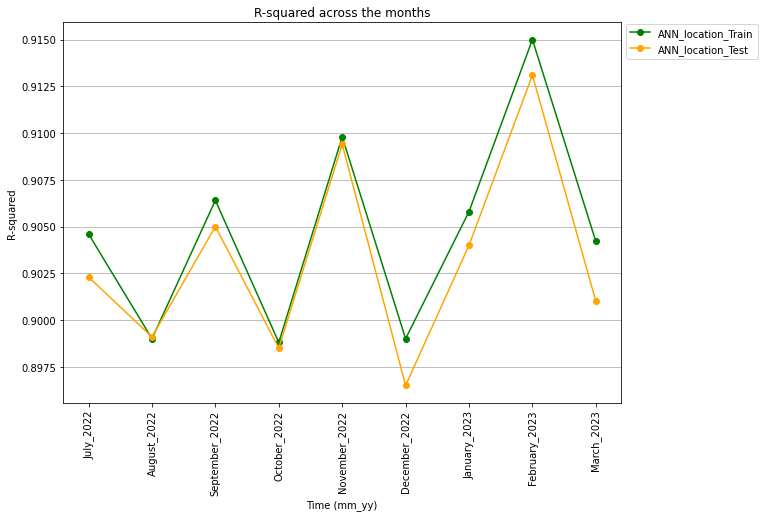

In [13]:
plt.figure(figsize = (10, 7))
plt.plot(df_trainlocation['avg_R2'], label = 'ANN_location_Train', marker = 'o', color = 'green')
plt.plot(df_testlocation['avg_R2'], label = 'ANN_location_Test', marker = 'o', color = 'orange')

plt.legend(bbox_to_anchor=(1,0.95), loc = 'center left')
plt.xticks(rotation = 'vertical')
plt.xlabel('Time (mm_yy)')
plt.ylabel('R-squared')
plt.title('R-squared across the months')
plt.grid(axis = 'y')
plt.show()

In [14]:
R2_result_location = df_trainlocation.copy().join(df_testlocation.copy(), rsuffix = '_test', lsuffix = '_train')
R2_result_location['DIF'] = np.absolute(R2_result_location['avg_R2_train'] - R2_result_location['avg_R2_test'])
R2_result_location[['avg_R2_train', 'avg_R2_test', 'DIF']]

,avg_R2_train,avg_R2_test,DIF
July_2022,0.9046,0.9023,0.0023
August_2022,0.8990,0.8991,0.0001
September_2022,0.9064,0.9050,0.0014
October_2022,0.8988,0.8985,0.0003
November_2022,0.9098,0.9094,0.0004
December_2022,0.8990,0.8965,0.0025
January_2023,0.9058,0.9040,0.0018
February_2023,0.9150,0.9131,0.0019
March_2023,0.9042,0.9010,0.0032


In [15]:
###This function is designed to join all the test sets together
def test_data(Month_list):
    monthly_test_dict = dict()
    for month in Month_list:
        df_list = list()
        for i in range(splits):
            path = 'Test'
            type_df = path.lower()
            path_data = 'Monthly_combination_ANN/' + path + '/' + month + '/' + 'original_' + type_df + '_result_Fold '+ str(i) + '.csv'
            df = pd.read_csv(path_data, index_col = 0)
            df_list.append(df)
        monthly_test_dict[month] = pd.concat(df_list, axis = 0)
    return monthly_test_dict

In [16]:
monthly_test_dict = test_data(Month_list)

In [17]:
monthly_test_dict['July_2022']['zpid'].tolist()

[220113867.0,
 78937736.0,
 78940690.0,
 220114072.0,
 252645579.0,
 2062207749.0,
 78939926.0,
 78949378.0,
 2062216122.0,
 239956826.0,
 2065580892.0,
 112328710.0,
 78948699.0,
 2062209030.0,
 127204612.0,
 2062254446.0,
 2062482405.0,
 2062482369.0,
 2062452151.0,
 2062586725.0,
 2063384040.0,
 2062482487.0,
 303970944.0,
 78942615.0,
 2062211005.0,
 78936718.0,
 78938460.0,
 2062317687.0,
 2062923497.0,
 2063384021.0,
 2063315279.0,
 2064287203.0,
 2063384054.0,
 2063384037.0,
 2062714293.0,
 2066669374.0,
 2062383987.0,
 2065400713.0,
 2062962270.0,
 2066589906.0,
 78938322.0,
 2063184171.0,
 2063493303.0,
 2062916387.0,
 2062963632.0,
 2063207915.0,
 2062340003.0,
 220097389.0,
 2062683249.0,
 2062552702.0,
 220109948.0,
 252645449.0,
 78936260.0,
 27262110.0,
 27332308.0,
 27318794.0,
 55170157.0,
 65698141.0,
 27284537.0,
 27316370.0,
 54021917.0,
 27296638.0,
 63409613.0,
 2114080251.0,
 27329712.0,
 333489626.0,
 54015513.0,
 69694994.0,
 27257115.0,
 27326809.0,
 89530237.0

In [18]:
monthly_test_dict['August_2022'][['livingAreaValue', 'lotArea', 'liv/lot_ratio', 'predicted_price/lotsqft',
                                  'predicted_living_price', 'predicted_price1', 'predicted_price2', 'actual_price']].corr()[['predicted_price1', 'predicted_price2', 'actual_price']]

,predicted_price1,predicted_price2,actual_price
livingAreaValue,0.895485,0.764251,0.794894
lotArea,0.266604,0.336701,0.239231
liv/lot_ratio,0.254873,0.164800,0.225866
predicted_price/lotsqft,0.395460,0.284000,0.358323
predicted_living_price,0.623380,0.620591,0.643943
predicted_price1,1.000000,0.850189,0.903794
predicted_price2,0.850189,1.000000,0.919479
actual_price,0.903794,0.919479,1.000000


In [19]:
for month, df in monthly_test_dict.items():
    df['AE'] = np.absolute(df['actual_price'] - df['predicted_price_comb'])
    df['APE'] = (df['AE']/df['actual_price']) * 100
    df['AE_price/lotsqft'] = np.absolute(df['actual_price/lotsqft'] - df['predicted_price/lotsqft'])
    df['APE_price/lotsqft'] = (df['AE_price/lotsqft']/df['actual_price/lotsqft']) * 100
    df['AE_living_price'] = np.absolute(df['actual_living_price'] - df['predicted_living_price'])
    df['APE_living_price'] = (df['AE_living_price']/df['actual_living_price']) * 100

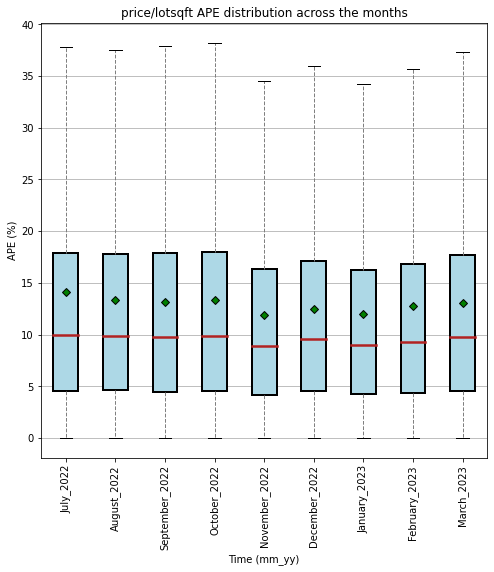

In [20]:
monthly_APE_location = dict()
for month, df in monthly_test_dict.items():
    monthly_APE_location[month] = df['APE_price/lotsqft']

fig, ax = plt.subplots(figsize = (8, 8))
boxprops = dict(linestyle='-', linewidth=2, color='black')
flierprops = dict(marker='o', markersize=5, markerfacecolor='red')
medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')
meanprops = dict(marker='D', markeredgecolor='black', markerfacecolor='green')
whiskerprops = dict(linestyle='--', linewidth=1, color='gray')

bp = ax.boxplot(monthly_APE_location.values(), showfliers=False, vert=True, showmeans=True,
                boxprops=boxprops, flierprops=flierprops, medianprops=medianprops,
                meanprops=meanprops, whiskerprops=whiskerprops, patch_artist=True)

colors = ['lightblue']*len(monthly_APE_location.keys())
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticklabels(monthly_APE_location.keys())
ax.set_ylabel("APE (%)")
ax.set_xlabel("Time (mm_yy)")

plt.grid(axis='y')
plt.xticks(rotation='vertical')
plt.title("price/lotsqft APE distribution across the months")
plt.show()

In [21]:
monthly_errors_location = dict()
for month, df in monthly_test_dict.items():
    ##first element
    errors_list = list()
    APE_median = df['APE_price/lotsqft'].median()
    errors_list.append(APE_median)
    AE_median = df['AE_price/lotsqft'].median()
    errors_list.append(AE_median)
    AE_mean = df['AE_price/lotsqft'].mean()
    errors_list.append(AE_mean)
    monthly_errors_location[month] = errors_list

In [22]:
df_errors = pd.DataFrame.from_dict(monthly_errors_location, orient='index', columns=['APE_median', 'AE_median', 'AE_mean'])
df_errors

,APE_median,AE_median,AE_mean
July_2022,9.938667,5.235964,8.375693
August_2022,9.894416,5.109490,8.148906
September_2022,9.772314,4.874505,7.820481
October_2022,9.897685,4.908894,7.907655
November_2022,8.888140,4.561916,7.421908
December_2022,9.553986,4.781315,7.772083
January_2023,8.969938,4.586188,7.458949
February_2023,9.259631,4.377261,7.337540
March_2023,9.715200,4.503594,7.766758


#### Plotting the average_R2 of train set vs. test_set on Living_price

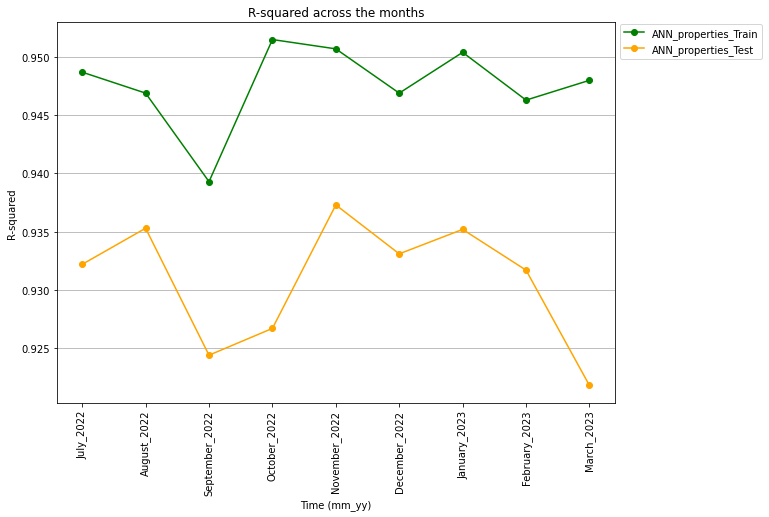

In [23]:
plt.figure(figsize = (10, 7))
plt.plot(df_trainlivingprice['avg_R2'], label = 'ANN_properties_Train', marker = 'o', color = 'green')
plt.plot(df_testlivingprice['avg_R2'], label = 'ANN_properties_Test', marker = 'o', color = 'orange')

plt.legend(bbox_to_anchor=(1,0.95), loc = 'center left')
plt.xticks(rotation = 'vertical')
plt.xlabel('Time (mm_yy)')
plt.ylabel('R-squared')
plt.title('R-squared across the months')
plt.grid(axis = 'y')
plt.show()

In [24]:
R2_result_living = df_trainlivingprice.copy().join(df_testlivingprice.copy(), rsuffix = '_test', lsuffix = '_train')
R2_result_living['DIF'] = np.absolute(R2_result_living['avg_R2_train'] - R2_result_living['avg_R2_test'])
R2_result_living[['avg_R2_train', 'avg_R2_test', 'DIF']]

,avg_R2_train,avg_R2_test,DIF
July_2022,0.9487,0.9322,0.0165
August_2022,0.9469,0.9353,0.0116
September_2022,0.9393,0.9244,0.0149
October_2022,0.9515,0.9267,0.0248
November_2022,0.9507,0.9373,0.0134
December_2022,0.9469,0.9331,0.0138
January_2023,0.9504,0.9352,0.0152
February_2023,0.9463,0.9317,0.0146
March_2023,0.9480,0.9218,0.0262


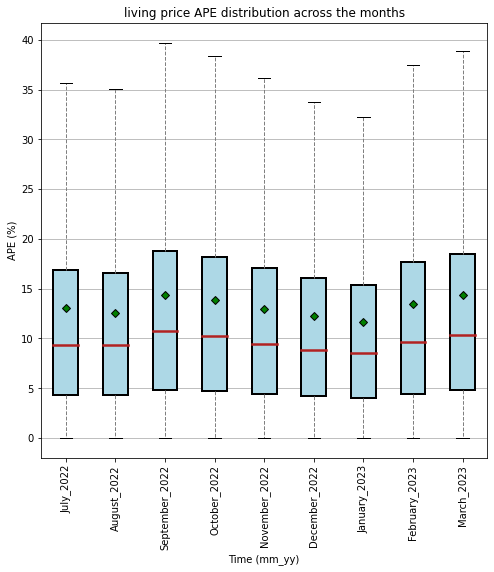

In [25]:
monthly_APE_properties = dict()
for month, df in monthly_test_dict.items():
    monthly_APE_properties[month] = df['APE_living_price']

fig, ax = plt.subplots(figsize = (8, 8))
boxprops = dict(linestyle='-', linewidth=2, color='black')
flierprops = dict(marker='o', markersize=5, markerfacecolor='red')
medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')
meanprops = dict(marker='D', markeredgecolor='black', markerfacecolor='green')
whiskerprops = dict(linestyle='--', linewidth=1, color='gray')

bp = ax.boxplot(monthly_APE_properties.values(), showfliers=False, vert=True, showmeans=True,
                boxprops=boxprops, flierprops=flierprops, medianprops=medianprops,
                meanprops=meanprops, whiskerprops=whiskerprops, patch_artist=True)

colors = ['lightblue']*len(monthly_APE_properties.keys())
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticklabels(monthly_APE_properties.keys())
ax.set_ylabel("APE (%)")
ax.set_xlabel("Time (mm_yy)")

plt.grid(axis='y')
plt.xticks(rotation='vertical')
plt.title("living price APE distribution across the months")
plt.show()

In [26]:
monthly_errors_properties = dict()
for month, df in monthly_test_dict.items():
    ##first element
    errors_list = list()
    APE_median = df['APE_living_price'].median()
    errors_list.append(APE_median)
    AE_median = df['AE_living_price'].median()
    errors_list.append(AE_median)
    AE_mean = df['AE_living_price'].mean()
    errors_list.append(AE_mean)
    monthly_errors_properties[month] = errors_list

df_errors = pd.DataFrame.from_dict(monthly_errors_properties, orient='index', columns=['APE_median', 'AE_median', 'AE_mean'])
df_errors

,APE_median,AE_median,AE_mean
July_2022,9.381904,10908.332585,20952.496572
August_2022,9.359620,10334.535795,19309.814019
September_2022,10.734396,11130.748524,20908.197104
October_2022,10.288059,10597.030580,20650.853351
November_2022,9.410107,10673.188681,19086.816985
December_2022,8.853642,9624.654116,18444.373176
January_2023,8.558819,9201.570967,18278.097955
February_2023,9.665587,9106.423184,18841.075400
March_2023,10.391547,10347.259394,20303.938128


#### Plotting the average_R2 of train set vs. test_set
1. Check if the model generalizes well.

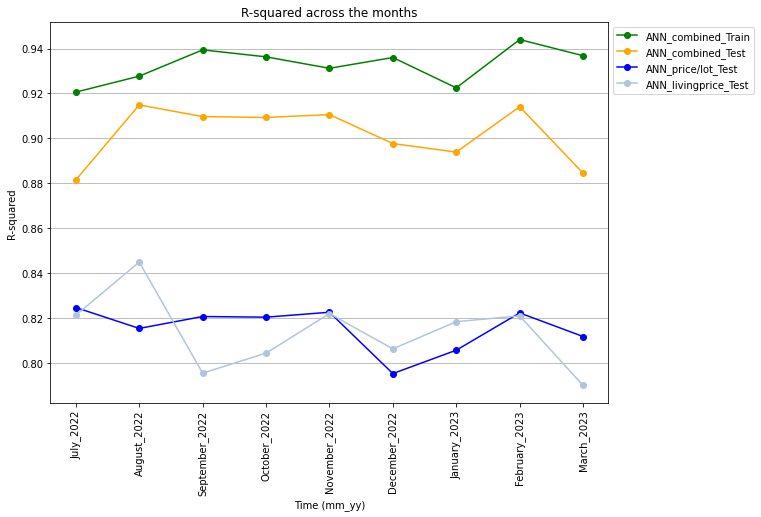

In [27]:
plt.figure(figsize = (10, 7))
plt.plot(df_trainhousingprice['avg_R2'], label = 'ANN_combined_Train', marker = 'o', color = 'green')
plt.plot(df_testhousingprice['avg_R2'], label = 'ANN_combined_Test', marker = 'o', color = 'orange')
plt.plot(df_test_predictedprice1['avg_R2'], label = 'ANN_price/lot_Test', marker = 'o', color = 'blue')
plt.plot(df_test_predictedprice2['avg_R2'], label = 'ANN_livingprice_Test', marker = 'o', color = 'lightsteelblue')

plt.legend(bbox_to_anchor=(1,0.9), loc = 'center left')
plt.xticks(rotation = 'vertical')
plt.xlabel('Time (mm_yy)')
plt.ylabel('R-squared')
plt.title('R-squared across the months')
plt.grid(axis = 'y')
plt.show()

In [28]:
R2_result = df_trainhousingprice.copy().join(df_testhousingprice.copy(), rsuffix = '_test', lsuffix = '_train')
R2_result['DIF'] = np.absolute(R2_result['avg_R2_train'] - R2_result['avg_R2_test'])
R2_result[['avg_R2_train', 'avg_R2_test', 'DIF']]

,avg_R2_train,avg_R2_test,DIF
July_2022,0.9206,0.8815,0.0391
August_2022,0.9277,0.9149,0.0128
September_2022,0.9394,0.9097,0.0297
October_2022,0.9363,0.9093,0.0270
November_2022,0.9312,0.9106,0.0206
December_2022,0.9360,0.8977,0.0383
January_2023,0.9225,0.8939,0.0286
February_2023,0.9440,0.9141,0.0299
March_2023,0.9368,0.8845,0.0523


#### Plotting the MAPE between train vs. test set
1. What is the average percentage error of the predictions

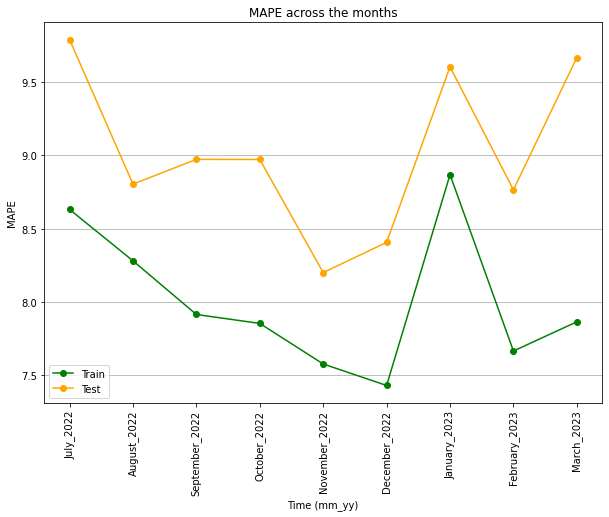

In [29]:
plt.figure(figsize = (10, 7))
plt.plot(df_trainhousingprice['avg_MAPE'], label = 'Train', marker = 'o', color = 'green')
plt.plot(df_testhousingprice['avg_MAPE'], label = 'Test', marker = 'o', color = 'orange')
plt.legend()
plt.xticks(rotation = 'vertical')
plt.xlabel('Time (mm_yy)')
plt.ylabel('MAPE')
plt.title('MAPE across the months')
plt.grid(axis = 'y')
plt.show()

In [30]:
MAPE_result = df_trainhousingprice.copy().join(df_testhousingprice.copy(), rsuffix = '_test', lsuffix = '_train')
MAPE_result[['avg_MAPE_train', 'avg_MAPE_test']]

,avg_MAPE_train,avg_MAPE_test
July_2022,8.6303,9.7880
August_2022,8.2801,8.8029
September_2022,7.9144,8.9714
October_2022,7.8536,8.9707
November_2022,7.5771,8.2001
December_2022,7.4307,8.4059
January_2023,8.8673,9.6020
February_2023,7.6655,8.7637
March_2023,7.8644,9.6656


#### Distribution of APE 
1. These distribution of errors can give us a clearer picture of how the model truly performs.
2. Get all the test sets together.
3. Get the distribution of AE of these test sets.

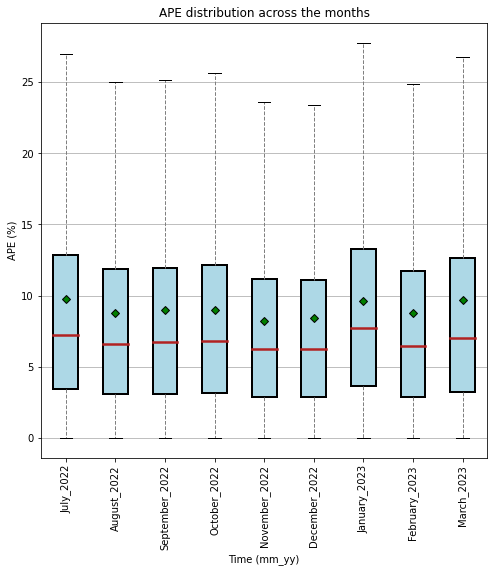

In [31]:
monthly_APE = dict()
for month, df in monthly_test_dict.items():
    monthly_APE[month] = df['APE']

fig, ax = plt.subplots(figsize = (8, 8))
boxprops = dict(linestyle='-', linewidth=2, color='black')
flierprops = dict(marker='o', markersize=5, markerfacecolor='red')
medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')
meanprops = dict(marker='D', markeredgecolor='black', markerfacecolor='green')
whiskerprops = dict(linestyle='--', linewidth=1, color='gray')

bp = ax.boxplot(monthly_APE.values(), showfliers=False, vert=True, showmeans=True,
                boxprops=boxprops, flierprops=flierprops, medianprops=medianprops,
                meanprops=meanprops, whiskerprops=whiskerprops, patch_artist=True)

colors = ['lightblue']*len(monthly_APE.keys())
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticklabels(monthly_APE.keys())
ax.set_ylabel("APE (%)")
ax.set_xlabel("Time (mm_yy)")

plt.grid(axis='y')
plt.xticks(rotation='vertical')
plt.title("APE distribution across the months")
plt.show()

In [32]:
monthly_errors = dict()
for month, df in monthly_test_dict.items():
    ##first element
    errors_list = list()
    APE_median = df['APE'].median()
    errors_list.append(APE_median)
    AE_median = df['AE'].median()
    errors_list.append(AE_median)
    monthly_errors[month] = errors_list

In [33]:
monthly_errors

{'July_2022': [7.256670826810032, 34010.899999999994],
 'August_2022': [6.632513694700272, 31014.859999999928],
 'September_2022': [6.735931766292485, 30445.185000000056],
 'October_2022': [6.841146202138164, 30807.434999999954],
 'November_2022': [6.21800530503979, 28762.340000000026],
 'December_2022': [6.26732439309964, 29009.79999999999],
 'January_2023': [7.7603673469387955, 35387.71999999997],
 'February_2023': [6.494179870663787, 28582.719999999972],
 'March_2023': [7.044265451627795, 31735.54999999999]}

In [34]:
df_errors = pd.DataFrame.from_dict(monthly_errors, orient='index', columns=['APE_median', 'AE_median'])
df_errors

,APE_median,AE_median
July_2022,7.256671,34010.900
August_2022,6.632514,31014.860
September_2022,6.735932,30445.185
October_2022,6.841146,30807.435
November_2022,6.218005,28762.340
December_2022,6.267324,29009.800
January_2023,7.760367,35387.720
February_2023,6.494180,28582.720
March_2023,7.044265,31735.550


## Create a map with APE and look at the linear actual values

In [40]:
###Plot distribution errors with January 2023
January_2023 = monthly_location2['January_2023']
January_2023

,zpid,latitude,longitude,county,SchoolDistrict,zipcode,liv/lot_ratio,price/lotsqft,price/livingsqft
0,7.893958e+07,33.244190,-97.588340,wise,decatur isd,76234,0.137741,25.451024,184.774436
1,9.736116e+07,33.043680,-97.399536,wise,northwest isd,76078,0.269553,44.089298,163.564580
2,2.060312e+09,33.160652,-97.899216,wise,jacksboro isd,76426,0.113198,22.647226,200.066711
3,2.093504e+09,33.359814,-97.391884,wise,slidell isd,76234,0.028535,6.634527,232.502011
4,2.201057e+08,33.243040,-97.585600,wise,decatur isd,76234,0.119648,17.143481,143.282102
...,...,...,...,...,...,...,...,...,...
11314,1.223067e+08,32.517906,-96.915016,ellis,midlothian isd,76065,0.040526,11.302602,278.896808
11315,2.066871e+09,32.539078,-96.842514,ellis,red oak isd,75154,0.126557,26.485720,209.279070
11316,3.312331e+08,32.348778,-96.840440,ellis,waxahachie isd,75165,0.107461,28.466483,264.900662
11317,2.062626e+09,32.454150,-96.962060,ellis,midlothian isd,76065,0.470271,94.685491,201.342446


In [41]:
df_location = January_2023.copy()[['zpid', 'latitude', 'longitude']]
df_Jan2023 = monthly_test_dict['January_2023'].copy()[['zpid', 'APE']]
df_Jan2023

,zpid,APE
9,2.060440e+09,40.842464
14,2.060142e+09,8.563431
16,2.060490e+09,0.228970
18,2.059926e+09,17.743508
31,2.070479e+09,7.959605
...,...,...
11288,2.063034e+09,6.080374
11298,2.060772e+09,10.054423
11299,2.060343e+09,4.690012
11301,2.062408e+09,14.686670


In [39]:
df_merged =  pd.merge(df_location, df_Jan2023, how = 'inner', on = 'zpid')
df_merged

,zpid,latitude,longitude,APE
0,7.893958e+07,33.244190,-97.588340,9.986816
1,9.736116e+07,33.043680,-97.399536,22.928986
2,2.060312e+09,33.160652,-97.899216,10.651677
3,2.093504e+09,33.359814,-97.391884,13.310152
4,2.201057e+08,33.243040,-97.585600,10.662533
...,...,...,...,...
11314,1.223067e+08,32.517906,-96.915016,16.122967
11315,2.066871e+09,32.539078,-96.842514,8.971948
11316,3.312331e+08,32.348778,-96.840440,26.933503
11317,2.062626e+09,32.454150,-96.962060,11.215372


In [43]:
df = January_2023.copy()
all_counties_list = np.sort(df['county'].unique())
counties_location_df = shape_df2.copy()
counties_location_df = counties_location_df[(counties_location_df['NAME'].isin(all_counties_list)) & 
                                            (counties_location_df['GEOID'].str.contains('48'))].reset_index(drop = True)

all_SD_list = np.sort(df['SchoolDistrict'].unique())
SD_location_df = shape_df3.copy()
SD_location_df = SD_location_df[SD_location_df['NAME'].isin(all_SD_list) &
                               (SD_location_df['INTPTLON'] >= -98.5) & 
                               (SD_location_df['INTPTLON'] <= -95.8) &
                               (SD_location_df['INTPTLAT'] >= 32) &
                               (SD_location_df['INTPTLAT'] <= 33.70)].reset_index(drop = True)

all_zipcode_list = np.sort(df['zipcode'].unique())
zipcode_location_df = shape_df4.copy()
zipcode_location_df = zipcode_location_df[zipcode_location_df['ZCTA5CE20'].isin(all_zipcode_list) &
                                          (zipcode_location_df['INTPTLON20'] >= -98.5) & 
                                          (zipcode_location_df['INTPTLON20'] <= -95.8) &
                                          (zipcode_location_df['INTPTLAT20'] >= 32) &
                                          (zipcode_location_df['INTPTLAT20'] <= 33.70)].reset_index(drop = True)

In [54]:
def plot_map_feature(month, location_df, shapely_df, location, feature, vmin, vmax):
    fig, ax = plt.subplots(figsize=(10,10))
    # Plot the base map
    cm = plt.cm.get_cmap('RdYlGn').reversed()
    lat = location_df['latitude'].to_numpy()
    long = location_df['longitude'].to_numpy()
    p = location_df[feature].to_numpy()

    loc_lat = shapely_df['INTPTLAT'].to_numpy()
    loc_long = shapely_df['INTPTLON'].to_numpy()

    shapely_df[['geometry']].plot(ax=ax, color='lightblue', linewidth = 1.2, edgecolor = 'darkblue', zorder = 1)
    ax0 = ax.scatter(long, lat, c = p, vmin = vmin, vmax = vmax, s = 3.5, cmap = cm, alpha = 0.8, zorder = 2)
    #plt.scatter(loc_long, loc_lat, s = 5, c = 'green', zorder = 3)

    #ax.set_xlim(-97.8, -96.2)
    #ax.set_ylim(32.3, 33.5)
    ax.set_title(month + " " + location + " and " + feature + " distribution")
    ax.set_xlabel('latitude')
    ax.set_ylabel('longtitude')
    fig.colorbar(ax0, shrink=0.62)
    fig.tight_layout()
    plt.show()

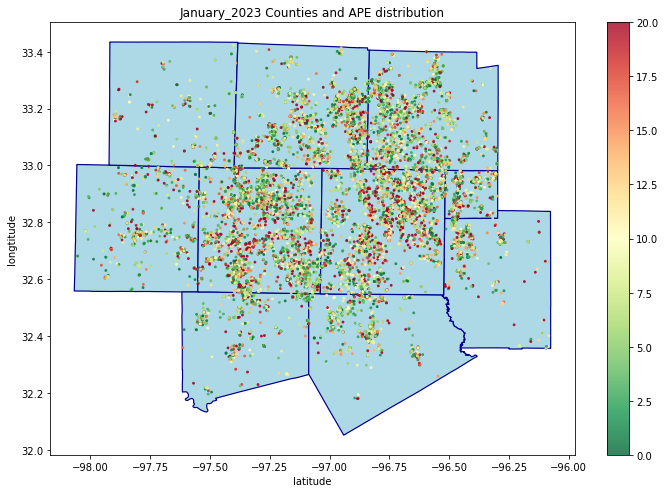

In [55]:
plot_map_feature('January_2023', df_merged, counties_location_df, 'Counties', "APE", 
                 vmin = 0, vmax = 20)

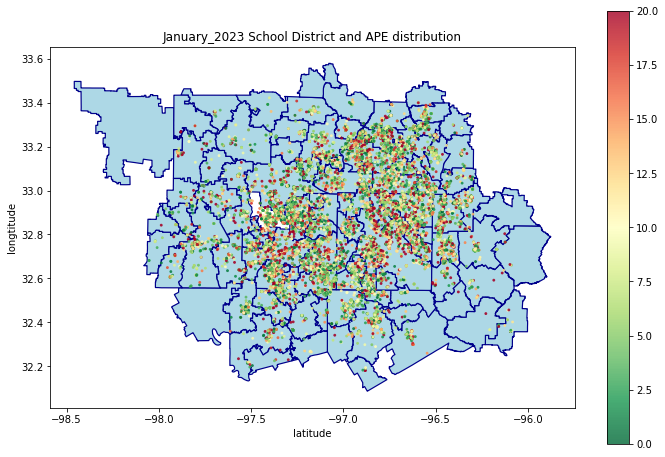

In [56]:
plot_map_feature('January_2023', df_merged, SD_location_df, 'School District', "APE", 
                 vmin = 0, vmax = 20)

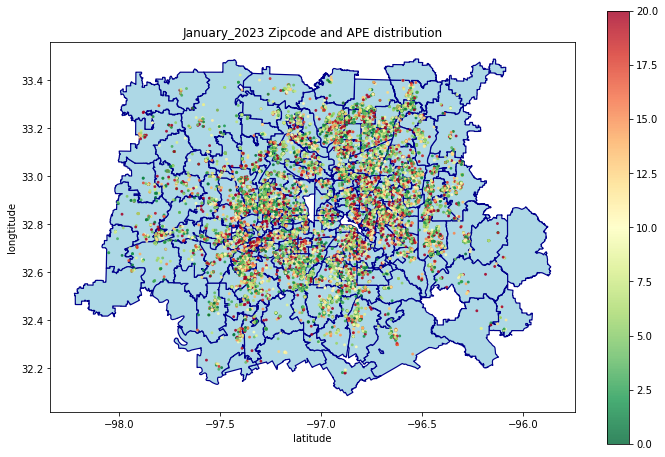

In [58]:
plot_map_feature('January_2023', df_merged, zipcode_location_df, 'Zipcode', "APE", 
                 vmin = 0, vmax = 20)

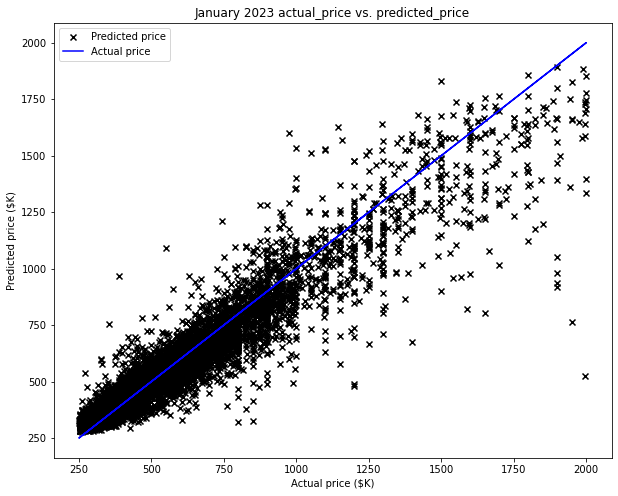

In [61]:
x = monthly_test_dict['January_2023']['actual_price']/1000
y = monthly_test_dict['January_2023']['predicted_price_comb']/1000

fig, ax = plt.subplots(figsize = (10, 8))
ax.scatter(x, y, color='black', marker = 'x', label='Predicted price')
ax.plot(x, x, color='blue', label='Actual price')
ax.set_xlabel('Actual price ($K)')
ax.set_ylabel('Predicted price ($K)')
ax.set_title('January 2023 actual_price vs. predicted_price')
ax.legend()
plt.show()

# Bug fixing section

In [25]:
##1. properties ANN doesn't produce the same result as before!!!
##Error: Code the wrong architecture.  (fixed)

In [26]:
monthly_data_dict1['July_2022']

,zpid,annualHomeownersInsurance,monthlyHoaFee,livingAreaValue,bedrooms,longitude,latitude,zipcode,city,mortgageRates.fifteenYearFixedRate,...,architecturalStyle_other,price/livingsqft,price/lotsqft,liv/lot_ratio,living_price,levels_multi/split,levels_one,levels_one and one half,levels_three or more,levels_two
0,2.201123e+08,626.0,0.0,1316.0,3.0,-97.488280,32.999400,76071,newark,4.369,...,0,113.221884,11.105745,0.098088,14615.159863,0,1,0,0,0
1,2.200985e+08,752.0,0.0,2849.0,3.0,-97.649800,33.098255,76023,boyd,4.369,...,0,62.829063,12.452347,0.198194,35476.737068,0,1,0,0,0
2,7.893662e+07,819.0,0.0,1492.0,3.0,-97.752600,33.206820,76426,bridgeport,4.369,...,1,130.697051,18.346656,0.140375,27373.210495,0,1,0,0,0
3,7.894290e+07,735.0,0.0,1168.0,2.0,-97.584150,33.232525,76234,decatur,4.369,...,0,149.828767,19.790380,0.132087,23115.164181,0,1,0,0,0
4,7.893668e+07,609.0,0.0,1072.0,2.0,-97.750490,33.218815,76426,bridgeport,4.369,...,0,135.261194,4.755346,0.035157,5097.730552,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13417,2.063034e+09,3557.0,163.0,3525.0,4.0,-96.961170,32.453842,76065,midlothian,4.454,...,0,240.255319,101.261191,0.421473,356945.699897,0,1,0,0,0
13418,2.063005e+09,3658.0,163.0,3525.0,4.0,-96.963196,32.453230,76065,midlothian,4.454,...,0,247.063830,104.130797,0.421473,367061.058023,0,1,0,0,0
13419,2.062622e+09,3549.0,83.0,3578.0,4.0,-96.961610,32.454163,76065,midlothian,4.454,...,0,236.137507,93.251130,0.394902,333652.543795,0,1,0,0,0
13420,2.063036e+09,3494.0,163.0,3714.0,4.0,-96.961380,32.454170,76065,midlothian,4.454,...,0,223.990307,91.816328,0.409912,341005.840750,0,1,0,0,0


In [27]:
monthly_location_dict1['July_2022']

,zpid,latitude,longitude,county_lat,county_long,SD_lat,SD_long,zipcode_lat,zipcode_long,price/livingsqft,price/lotsqft,liv/lot_ratio
0,2.201123e+08,32.999400,-97.488280,33.219095,-97.653997,33.033006,-97.354880,33.011335,-97.474362,113.221884,11.105745,0.098088
1,2.200985e+08,33.098255,-97.649800,33.219095,-97.653997,33.072593,-97.579633,33.041952,-97.597065,62.829063,12.452347,0.198194
2,7.893662e+07,33.206820,-97.752600,33.219095,-97.653997,33.157978,-97.816943,33.160060,-97.840034,130.697051,18.346656,0.140375
3,7.894290e+07,33.232525,-97.584150,33.219095,-97.653997,33.237630,-97.539224,33.276319,-97.514178,149.828767,19.790380,0.132087
4,7.893668e+07,33.218815,-97.750490,33.219095,-97.653997,33.157978,-97.816943,33.160060,-97.840034,135.261194,4.755346,0.035157
...,...,...,...,...,...,...,...,...,...,...,...,...
13417,2.063034e+09,32.453842,-96.961170,32.346878,-96.796940,32.472297,-97.000465,32.469436,-96.990670,240.255319,101.261191,0.421473
13418,2.063005e+09,32.453230,-96.963196,32.346878,-96.796940,32.472297,-97.000465,32.469436,-96.990670,247.063830,104.130797,0.421473
13419,2.062622e+09,32.454163,-96.961610,32.346878,-96.796940,32.472297,-97.000465,32.469436,-96.990670,236.137507,93.251130,0.394902
13420,2.063036e+09,32.454170,-96.961380,32.346878,-96.796940,32.472297,-97.000465,32.469436,-96.990670,223.990307,91.816328,0.409912


In [28]:
Month_path = 'Location_data3/July_2022/July_2022_houses_location.csv'
df_location = pd.read_csv(Month_path)
df_location

,zpid,latitude,longitude,county_lat,county_long,SD_lat,SD_long,zipcode_lat,zipcode_long,price/livingsqft,price/lotsqft,liv/lot_ratio
0,2.201123e+08,32.999400,-97.488280,33.219095,-97.653997,33.033006,-97.354880,33.011335,-97.474362,113.221884,11.105745,0.098088
1,2.200985e+08,33.098255,-97.649800,33.219095,-97.653997,33.072593,-97.579633,33.041952,-97.597065,62.829063,12.452347,0.198194
2,7.893662e+07,33.206820,-97.752600,33.219095,-97.653997,33.157978,-97.816943,33.160060,-97.840034,130.697051,18.346656,0.140375
3,7.894290e+07,33.232525,-97.584150,33.219095,-97.653997,33.237630,-97.539224,33.276319,-97.514178,149.828767,19.790380,0.132087
4,7.893668e+07,33.218815,-97.750490,33.219095,-97.653997,33.157978,-97.816943,33.160060,-97.840034,135.261194,4.755346,0.035157
...,...,...,...,...,...,...,...,...,...,...,...,...
13417,2.063034e+09,32.453842,-96.961170,32.346878,-96.796940,32.472297,-97.000465,32.469436,-96.990670,240.255319,101.261191,0.421473
13418,2.063005e+09,32.453230,-96.963196,32.346878,-96.796940,32.472297,-97.000465,32.469436,-96.990670,247.063830,104.130797,0.421473
13419,2.062622e+09,32.454163,-96.961610,32.346878,-96.796940,32.472297,-97.000465,32.469436,-96.990670,236.137507,93.251130,0.394902
13420,2.063036e+09,32.454170,-96.961380,32.346878,-96.796940,32.472297,-97.000465,32.469436,-96.990670,223.990307,91.816328,0.409912


In [29]:
July_2022df = pd.read_csv('Monthly_combination_ANN/Test/July_2022/original_test_result_Fold 0.csv', index_col = 0)

In [30]:
column1 = monthly_data_dict1['July_2022']['zpid']
column2 = df_location['zpid']

df = monthly_data_dict1['July_2022']
df_model2 = transform_data(df.copy(), True_False_features, Numerical_features, Categorical_features)

# Check if the columns have the same variable values in the same order
if len(column1) != len(column2):
    print("Columns have different lengths")
else:
    for i in range(len(column2)):
        if column1[i] != column2[i]:
            print("Columns have different values in position", i)
            break
    else:
        print("Columns have the same values in the same order")

Columns have the same values in the same order
